# IMU Path Length Analysis

This notebook analyzes IMU acceleration data to compute the length of a walking path based on phone movement patterns during walking motion.

## Methodology
1. **Load and process IMU data** (accelerometer + gyroscope if available)
2. **Remove gravity bias** using advanced gravity compensation techniques
3. **Integrate acceleration** to obtain velocity and position trajectories
4. **Compute path length** from the accumulated distance traveled
5. **Validate results** with multiple approaches and error analysis

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.integrate import cumulative_trapezoid, cumulative_simpson
from scipy.ndimage import gaussian_filter1d
import os

# Set up plotting
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)

# Configuration: Select which datasets to use
CONFIG = {
    'path_file': 'bjorn_path_new.txt',      # Main path measurement file
    'stationary_file': 'bjorn_stationary_new.txt',  # Stationary reference file
    'integration_method': 'trapezoid',      # 'trapezoid' or 'simpson'
    'gravity_compensation': 'auto',         # 'static', 'orientation', 'auto'
    'enable_filtering': False,              # Apply low-pass filtering to acceleration
    'filter_cutoff': 2.0,                   # Low-pass filter cutoff frequency (Hz)
    'smoothing_sigma': 2.0,                 # Gaussian smoothing for gravity estimates
    'stationary_threshold': 0.01,           # Gyro threshold for stationary detection (rad/s)
    'print_debug': True                     # Enable debug output
}

print("IMU Path Length Analysis Configuration:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")
print()

IMU Path Length Analysis Configuration:
  path_file: bjorn_path_new.txt
  stationary_file: bjorn_stationary_new.txt
  integration_method: trapezoid
  gravity_compensation: auto
  enable_filtering: False
  filter_cutoff: 2.0
  smoothing_sigma: 2.0
  stationary_threshold: 0.01
  print_debug: True



In [8]:
def load_imu_data_enhanced(filepath):
    """
    Load IMU data from text file with support for both accelerometer and gyroscope data
    Returns: (merged_dataframe, has_gyro, gyro_dataframe)
    """
    acc_data = []
    gyro_data = []
    
    try:
        with open(filepath, 'r') as f:
            for line in f:
                parts = line.strip().split('\t')
                if len(parts) == 5:
                    timestamp = int(parts[0])
                    if parts[1] == 'ACC':
                        acc_x = float(parts[2])
                        acc_y = float(parts[3])
                        acc_z = float(parts[4])
                        acc_data.append([timestamp, acc_x, acc_y, acc_z])
                    elif parts[1] == 'GYR':
                        gyro_x = float(parts[2])
                        gyro_y = float(parts[3])
                        gyro_z = float(parts[4])
                        gyro_data.append([timestamp, gyro_x, gyro_y, gyro_z])
    except Exception as e:
        print(f"Error reading file {filepath}: {e}")
        return None, False, None
    
    # Create accelerometer DataFrame
    if not acc_data:
        print(f"No accelerometer data found in {filepath}")
        return None, False, None
        
    acc_df = pd.DataFrame(acc_data, columns=['timestamp', 'acc_x', 'acc_y', 'acc_z'])
    acc_df['time'] = (acc_df['timestamp'] - acc_df['timestamp'].iloc[0]) / 1000.0
    
    # Create gyroscope DataFrame if data exists
    has_gyro = len(gyro_data) > 0
    gyro_df = None
    
    if has_gyro:
        gyro_df = pd.DataFrame(gyro_data, columns=['timestamp', 'gyro_x', 'gyro_y', 'gyro_z'])
        gyro_df['time'] = (gyro_df['timestamp'] - gyro_df['timestamp'].iloc[0]) / 1000.0
        
        # Interpolate gyro data to match accelerometer timestamps
        merged_df = acc_df.copy()
        merged_df['gyro_x'] = np.interp(acc_df['timestamp'], gyro_df['timestamp'], gyro_df['gyro_x'])
        merged_df['gyro_y'] = np.interp(acc_df['timestamp'], gyro_df['timestamp'], gyro_df['gyro_y'])
        merged_df['gyro_z'] = np.interp(acc_df['timestamp'], gyro_df['timestamp'], gyro_df['gyro_z'])
        
        return merged_df, has_gyro, gyro_df
    else:
        return acc_df, has_gyro, None

def detect_stationary_periods_robust(acc_data, gyro_data=None, 
                                   gyro_threshold=0.01, 
                                   acc_var_threshold=0.1,
                                   gravity_tolerance=0.5,
                                   window_size=50):
    """
    Robust stationary period detection using both accelerometer and gyroscope
    """
    n_samples = len(acc_data)
    stationary_mask = np.zeros(n_samples, dtype=bool)
    
    # Calculate accelerometer magnitude and check if close to gravity
    acc_magnitude = np.sqrt(acc_data['acc_x']**2 + acc_data['acc_y']**2 + acc_data['acc_z']**2)
    gravity_condition = np.abs(acc_magnitude - 9.81) < gravity_tolerance
    
    # Calculate accelerometer variance (low variance indicates stationary)
    acc_var = np.zeros(n_samples)
    for i in range(window_size//2, n_samples - window_size//2):
        window_start = i - window_size//2
        window_end = i + window_size//2
        window_acc = acc_data[['acc_x', 'acc_y', 'acc_z']].iloc[window_start:window_end]
        acc_var[i] = np.mean(np.var(window_acc, axis=0))
    
    acc_var_condition = acc_var < acc_var_threshold
    
    if gyro_data is not None:
        # Use gyroscope for more accurate stationary detection
        gyro_magnitude = np.sqrt(gyro_data['gyro_x']**2 + gyro_data['gyro_y']**2 + gyro_data['gyro_z']**2)
        gyro_condition = gyro_magnitude < gyro_threshold
        
        # Combine all conditions
        stationary_mask = gravity_condition & acc_var_condition & gyro_condition
        
        if CONFIG['print_debug']:
            print(f"Stationary detection with gyroscope:")
            print(f"  Gyro threshold: {gyro_threshold} rad/s")
            print(f"  Acc variance threshold: {acc_var_threshold}")
            print(f"  Gravity tolerance: ±{gravity_tolerance} m/s²")
    else:
        # Use only accelerometer-based detection
        stationary_mask = gravity_condition & acc_var_condition
        
        if CONFIG['print_debug']:
            print(f"Stationary detection without gyroscope:")
            print(f"  Acc variance threshold: {acc_var_threshold}")
            print(f"  Gravity tolerance: ±{gravity_tolerance} m/s²")
    
    # Apply smoothing to stationary mask
    stationary_smooth = pd.Series(stationary_mask.astype(float)).rolling(
        window=window_size, center=True, min_periods=1).mean()
    final_stationary = stationary_smooth > 0.7
    
    if CONFIG['print_debug']:
        print(f"  Found {final_stationary.sum()} stationary samples out of {n_samples} ({100*final_stationary.sum()/n_samples:.1f}%)")
    
    return final_stationary, acc_magnitude, acc_var

# Load the configured datasets
current_dir = os.getcwd()
print(f"Current working directory: {current_dir}")
print(f"Loading datasets with configuration:")
print(f"  Path file: {CONFIG['path_file']}")
print(f"  Stationary file: {CONFIG['stationary_file']}")
print()

Current working directory: /media/shekharu/DATA/OneDrive/SMaRC PhD/Courses/WASP Autonomous Systems/imu-inchtape/path-data
Loading datasets with configuration:
  Path file: bjorn_path_new.txt
  Stationary file: bjorn_stationary_new.txt



In [9]:
# Load the datasets
path_data, path_has_gyro, path_gyro_df = load_imu_data_enhanced(CONFIG['path_file'])
stationary_data, stationary_has_gyro, stationary_gyro_df = load_imu_data_enhanced(CONFIG['stationary_file'])

if path_data is None:
    raise ValueError(f"Could not load path data from {CONFIG['path_file']}")

print("=== DATASET LOADING RESULTS ===")
print(f"Path data: {len(path_data)} samples, duration: {path_data['time'].iloc[-1]:.1f}s, has gyro: {path_has_gyro}")

if stationary_data is not None:
    print(f"Stationary data: {len(stationary_data)} samples, duration: {stationary_data['time'].iloc[-1]:.1f}s, has gyro: {stationary_has_gyro}")
else:
    print("Warning: No stationary reference data available")

# Store datasets in a unified structure
datasets = {
    'path': {
        'data': path_data,
        'has_gyro': path_has_gyro,
        'gyro_data': path_gyro_df,
        'type': 'motion',
        'name': 'Path Motion Data'
    }
}

if stationary_data is not None:
    datasets['stationary'] = {
        'data': stationary_data,
        'has_gyro': stationary_has_gyro,
        'gyro_data': stationary_gyro_df,
        'type': 'stationary', 
        'name': 'Stationary Reference Data'
    }

print(f"\nLoaded {len(datasets)} datasets successfully")
print()

=== DATASET LOADING RESULTS ===
Path data: 35856 samples, duration: 180.8s, has gyro: False
Stationary data: 1638 samples, duration: 8.3s, has gyro: False

Loaded 2 datasets successfully



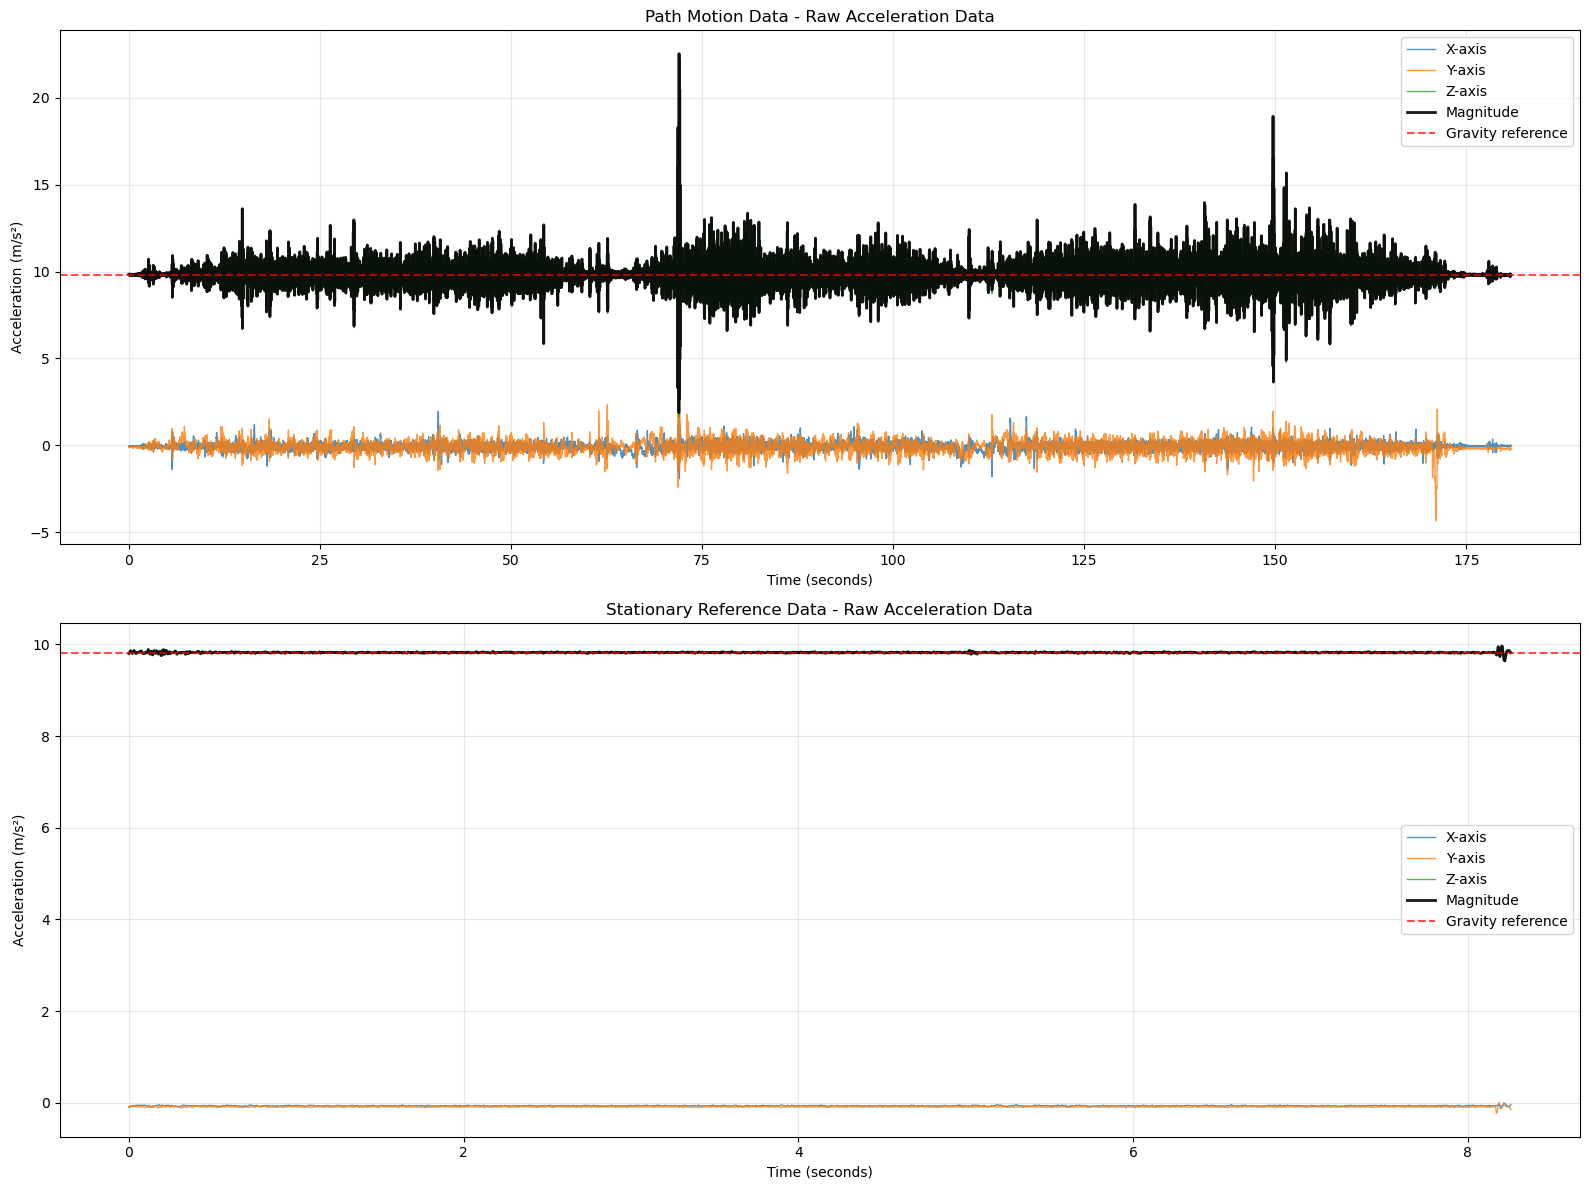

Raw acceleration data visualization complete
Expected gravity magnitude: ~9.81 m/s²
Path data acceleration magnitude: mean=9.83, std=0.65 m/s²


In [10]:
# Visualize raw acceleration data
fig, axes = plt.subplots(len(datasets), 1, figsize=(16, 6*len(datasets)))

if len(datasets) == 1:
    axes = [axes]

for i, (key, dataset_info) in enumerate(datasets.items()):
    data = dataset_info['data']
    title = dataset_info['name']
    
    ax = axes[i]
    ax.plot(data['time'], data['acc_x'], label='X-axis', alpha=0.8, linewidth=1)
    ax.plot(data['time'], data['acc_y'], label='Y-axis', alpha=0.8, linewidth=1)
    ax.plot(data['time'], data['acc_z'], label='Z-axis', alpha=0.8, linewidth=1)
    
    # Show acceleration magnitude
    acc_magnitude = np.sqrt(data['acc_x']**2 + data['acc_y']**2 + data['acc_z']**2)
    ax.plot(data['time'], acc_magnitude, label='Magnitude', alpha=0.9, linewidth=2, color='black')
    ax.axhline(y=9.81, color='red', linestyle='--', alpha=0.7, label='Gravity reference')
    
    ax.set_title(f'{title} - Raw Acceleration Data')
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Acceleration (m/s²)')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Raw acceleration data visualization complete")
print(f"Expected gravity magnitude: ~9.81 m/s²")
if 'path' in datasets:
    path_acc_mag = np.sqrt(datasets['path']['data']['acc_x']**2 + 
                          datasets['path']['data']['acc_y']**2 + 
                          datasets['path']['data']['acc_z']**2)
    print(f"Path data acceleration magnitude: mean={path_acc_mag.mean():.2f}, std={path_acc_mag.std():.2f} m/s²")

## Gravity Compensation

We'll implement multiple gravity compensation strategies:

1. **Static Bias Removal**: Use stationary reference data to estimate constant gravity bias
2. **Orientation-Based Compensation**: Use gyroscope integration to track device orientation changes (improved from IMU tricks)
3. **Auto Selection**: Automatically choose the best method based on available sensor data

The goal is to remove the gravity component from acceleration measurements to isolate the motion-induced accelerations.

In [11]:
def estimate_static_gravity_bias(stationary_data, use_robust_method=True):
    """
    Estimate gravity bias from stationary data using robust statistical methods
    """
    if stationary_data is None:
        return None, None, None
    
    if use_robust_method:
        # Use median for robustness against outliers
        gravity_x = stationary_data['acc_x'].median()
        gravity_y = stationary_data['acc_y'].median() 
        gravity_z = stationary_data['acc_z'].median()
        
        if CONFIG['print_debug']:
            print("Static gravity estimation (robust median):")
    else:
        # Use mean for traditional approach
        gravity_x = stationary_data['acc_x'].mean()
        gravity_y = stationary_data['acc_y'].mean()
        gravity_z = stationary_data['acc_z'].mean()
        
        if CONFIG['print_debug']:
            print("Static gravity estimation (mean):")
    
    gravity_magnitude = np.sqrt(gravity_x**2 + gravity_y**2 + gravity_z**2)
    
    if CONFIG['print_debug']:
        print(f"  Gravity vector: ({gravity_x:.3f}, {gravity_y:.3f}, {gravity_z:.3f}) m/s²")
        print(f"  Gravity magnitude: {gravity_magnitude:.3f} m/s²")
        print(f"  Deviation from 9.81: {abs(gravity_magnitude - 9.81):.3f} m/s²")
    
    return gravity_x, gravity_y, gravity_z

def estimate_gravity_from_stationary_periods(acc_data, gyro_data=None):
    """
    Estimate gravity by identifying stationary periods within the motion data
    """
    stationary_mask, acc_mag, acc_var = detect_stationary_periods_robust(
        acc_data, gyro_data, 
        gyro_threshold=CONFIG['stationary_threshold'],
        window_size=50
    )
    
    if stationary_mask.sum() < 10:  # Need at least 10 stationary samples
        if CONFIG['print_debug']:
            print("Warning: Insufficient stationary periods detected in motion data")
        return None, None, None, None
    
    # Calculate gravity from detected stationary periods
    stationary_acc = acc_data[stationary_mask]
    gravity_x = stationary_acc['acc_x'].median()
    gravity_y = stationary_acc['acc_y'].median()
    gravity_z = stationary_acc['acc_z'].median()
    
    if CONFIG['print_debug']:
        print(f"Gravity from motion data stationary periods:")
        print(f"  Used {stationary_mask.sum()} stationary samples ({100*stationary_mask.sum()/len(acc_data):.1f}%)")
        print(f"  Gravity vector: ({gravity_x:.3f}, {gravity_y:.3f}, {gravity_z:.3f}) m/s²")
        gravity_magnitude = np.sqrt(gravity_x**2 + gravity_y**2 + gravity_z**2)
        print(f"  Gravity magnitude: {gravity_magnitude:.3f} m/s²")
    
    return gravity_x, gravity_y, gravity_z, stationary_mask

def improved_orientation_based_gravity(acc_data, gyro_data, initial_gravity_norm=9.81):
    """
    Improved orientation-based gravity compensation with better numerical stability
    """
    if gyro_data is None:
        raise ValueError("Gyroscope data required for orientation-based compensation")
    
    # Estimate initial gravity direction from first few samples (assuming initial stationary period)
    initial_window = min(100, len(acc_data) // 10)
    initial_acc = acc_data[['acc_x', 'acc_y', 'acc_z']].iloc[:initial_window].median()
    initial_acc_norm = np.sqrt(initial_acc['acc_x']**2 + initial_acc['acc_y']**2 + initial_acc['acc_z']**2)
    
    if initial_acc_norm > 0:
        gravity_device_initial = np.array([initial_acc['acc_x'], initial_acc['acc_y'], initial_acc['acc_z']]) / initial_acc_norm * initial_gravity_norm
    else:
        gravity_device_initial = np.array([0, 0, initial_gravity_norm])  # fallback
    
    if CONFIG['print_debug']:
        print(f"Improved orientation-based gravity compensation:")
        print(f"  Initial gravity estimate: ({gravity_device_initial[0]:.3f}, {gravity_device_initial[1]:.3f}, {gravity_device_initial[2]:.3f}) m/s²")
    
    # Initialize arrays
    n_samples = len(acc_data)
    gravity_estimates = np.zeros((n_samples, 3))
    gravity_estimates[0] = gravity_device_initial
    
    # Calculate time intervals with better handling
    time_array = acc_data['time'].values
    dt_array = np.diff(time_array)
    dt_array = np.append(dt_array, dt_array[-1])  # Use last interval for final point
    
    # Numerical integration with improved stability
    current_gravity = gravity_device_initial.copy()
    
    for i in range(1, n_samples):
        dt = dt_array[i-1]
        
        # Skip integration if time step is too large (indicates data gap)
        if dt > 0.1:  # 100ms threshold
            gravity_estimates[i] = current_gravity
            continue
            
        # Get gyroscope readings
        omega = np.array([
            gyro_data['gyro_x'].iloc[i],
            gyro_data['gyro_y'].iloc[i],
            gyro_data['gyro_z'].iloc[i]
        ])
        
        omega_magnitude = np.linalg.norm(omega)
        
        # Apply rotation only if significant rotation detected
        if omega_magnitude > 1e-4:  # Threshold to avoid noise amplification
            # Use small-angle approximation for better numerical stability
            if omega_magnitude * dt < 0.1:  # Small angle (< ~6 degrees)
                # Small angle approximation: R ≈ I + [ω]× * dt
                omega_cross = np.array([
                    [0, -omega[2], omega[1]],
                    [omega[2], 0, -omega[0]],
                    [-omega[1], omega[0], 0]
                ]) * dt
                
                current_gravity = current_gravity + omega_cross @ current_gravity
            else:
                # Use Rodrigues' formula for larger rotations
                axis = omega / omega_magnitude
                angle = omega_magnitude * dt
                
                cos_angle = np.cos(angle)
                sin_angle = np.sin(angle)
                
                current_gravity = (current_gravity * cos_angle +
                                 np.cross(axis, current_gravity) * sin_angle +
                                 axis * np.dot(axis, current_gravity) * (1 - cos_angle))
        
        gravity_estimates[i] = current_gravity
    
    # Apply smoothing to reduce integration noise
    gravity_x_smooth = gaussian_filter1d(gravity_estimates[:, 0], sigma=CONFIG['smoothing_sigma'])
    gravity_y_smooth = gaussian_filter1d(gravity_estimates[:, 1], sigma=CONFIG['smoothing_sigma'])
    gravity_z_smooth = gaussian_filter1d(gravity_estimates[:, 2], sigma=CONFIG['smoothing_sigma'])
    
    # Create DataFrame
    gravity_df = pd.DataFrame({
        'time': acc_data['time'],
        'gravity_x': gravity_x_smooth,
        'gravity_y': gravity_y_smooth,
        'gravity_z': gravity_z_smooth
    })
    
    if CONFIG['print_debug']:
        gravity_magnitude = np.sqrt(gravity_x_smooth**2 + gravity_y_smooth**2 + gravity_z_smooth**2)
        print(f"  Final gravity magnitude: mean={gravity_magnitude.mean():.3f}, std={gravity_magnitude.std():.3f} m/s²")
        print(f"  Gravity range X: [{gravity_x_smooth.min():.3f}, {gravity_x_smooth.max():.3f}] m/s²")
        print(f"  Gravity range Y: [{gravity_y_smooth.min():.3f}, {gravity_y_smooth.max():.3f}] m/s²")
        print(f"  Gravity range Z: [{gravity_z_smooth.min():.3f}, {gravity_z_smooth.max():.3f}] m/s²")
    
    return gravity_df

print("Gravity compensation functions defined successfully")

Gravity compensation functions defined successfully


In [12]:
# Apply gravity compensation to path data
print("=== GRAVITY COMPENSATION ANALYSIS ===")

path_data_corrected = None
gravity_method_used = None

# Determine which gravity compensation method to use
if CONFIG['gravity_compensation'] == 'auto':
    # Auto-select best method based on available data
    if path_has_gyro and 'stationary' in datasets:
        gravity_method_used = 'orientation'
        print("Auto-selected: Orientation-based compensation (gyro + stationary reference available)")
    elif 'stationary' in datasets:
        gravity_method_used = 'static'
        print("Auto-selected: Static compensation (stationary reference available)")
    elif path_has_gyro:
        gravity_method_used = 'stationary_periods'
        print("Auto-selected: Stationary periods from motion data (gyro available)")
    else:
        gravity_method_used = 'fallback'
        print("Auto-selected: Fallback median compensation (limited sensor data)")
elif CONFIG['gravity_compensation'] in ['static', 'orientation', 'stationary_periods']:
    gravity_method_used = CONFIG['gravity_compensation']
    print(f"User-selected: {gravity_method_used} compensation")
else:
    raise ValueError(f"Unknown gravity compensation method: {CONFIG['gravity_compensation']}")

# Apply the selected compensation method
if gravity_method_used == 'static' and 'stationary' in datasets:
    # Static bias removal using stationary reference
    gravity_x, gravity_y, gravity_z = estimate_static_gravity_bias(datasets['stationary']['data'])
    
    if gravity_x is not None:
        path_data_corrected = path_data.copy()
        path_data_corrected['acc_x_corrected'] = path_data['acc_x'] - gravity_x
        path_data_corrected['acc_y_corrected'] = path_data['acc_y'] - gravity_y
        path_data_corrected['acc_z_corrected'] = path_data['acc_z'] - gravity_z
        path_data_corrected['gravity_x_est'] = gravity_x
        path_data_corrected['gravity_y_est'] = gravity_y
        path_data_corrected['gravity_z_est'] = gravity_z
        print("Applied static gravity compensation successfully")

elif gravity_method_used == 'orientation' and path_has_gyro:
    # Orientation-based compensation
    try:
        gravity_estimates = improved_orientation_based_gravity(path_data, path_data)
        path_data_corrected = path_data.copy()
        path_data_corrected['acc_x_corrected'] = path_data['acc_x'] - gravity_estimates['gravity_x']
        path_data_corrected['acc_y_corrected'] = path_data['acc_y'] - gravity_estimates['gravity_y']
        path_data_corrected['acc_z_corrected'] = path_data['acc_z'] - gravity_estimates['gravity_z']
        path_data_corrected['gravity_x_est'] = gravity_estimates['gravity_x']
        path_data_corrected['gravity_y_est'] = gravity_estimates['gravity_y']
        path_data_corrected['gravity_z_est'] = gravity_estimates['gravity_z']
        print("Applied orientation-based gravity compensation successfully")
    except Exception as e:
        print(f"Orientation-based compensation failed: {e}")
        gravity_method_used = 'fallback'

elif gravity_method_used == 'stationary_periods' and path_has_gyro:
    # Use stationary periods within motion data
    gravity_x, gravity_y, gravity_z, stationary_mask = estimate_gravity_from_stationary_periods(path_data, path_data)
    
    if gravity_x is not None:
        path_data_corrected = path_data.copy()
        path_data_corrected['acc_x_corrected'] = path_data['acc_x'] - gravity_x
        path_data_corrected['acc_y_corrected'] = path_data['acc_y'] - gravity_y
        path_data_corrected['acc_z_corrected'] = path_data['acc_z'] - gravity_z
        path_data_corrected['gravity_x_est'] = gravity_x
        path_data_corrected['gravity_y_est'] = gravity_y
        path_data_corrected['gravity_z_est'] = gravity_z
        path_data_corrected['stationary_mask'] = stationary_mask
        print("Applied stationary periods gravity compensation successfully")
    else:
        gravity_method_used = 'fallback'

# Fallback method: use median of motion data (not ideal but better than nothing)
if gravity_method_used == 'fallback' or path_data_corrected is None:
    print("Using fallback gravity compensation (median of motion data)")
    gravity_x = path_data['acc_x'].median()
    gravity_y = path_data['acc_y'].median()
    gravity_z = path_data['acc_z'].median()
    
    path_data_corrected = path_data.copy()
    path_data_corrected['acc_x_corrected'] = path_data['acc_x'] - gravity_x
    path_data_corrected['acc_y_corrected'] = path_data['acc_y'] - gravity_y
    path_data_corrected['acc_z_corrected'] = path_data['acc_z'] - gravity_z
    path_data_corrected['gravity_x_est'] = gravity_x
    path_data_corrected['gravity_y_est'] = gravity_y
    path_data_corrected['gravity_z_est'] = gravity_z
    gravity_method_used = 'fallback'

print(f"\nFinal gravity compensation method: {gravity_method_used}")
print(f"Gravity-corrected data shape: {path_data_corrected.shape}")

# Validate gravity compensation
corrected_magnitude = np.sqrt(path_data_corrected['acc_x_corrected']**2 + 
                            path_data_corrected['acc_y_corrected']**2 + 
                            path_data_corrected['acc_z_corrected']**2)

print(f"\nGravity compensation validation:")
print(f"  Mean corrected acceleration magnitude: {corrected_magnitude.mean():.3f} m/s²")
print(f"  Std corrected acceleration magnitude: {corrected_magnitude.std():.3f} m/s²")
print(f"  Expected: close to 0 for stationary periods, variable for motion")
print()

=== GRAVITY COMPENSATION ANALYSIS ===
Auto-selected: Static compensation (stationary reference available)
Static gravity estimation (robust median):
  Gravity vector: (-0.068, -0.094, 9.823) m/s²
  Gravity magnitude: 9.824 m/s²
  Deviation from 9.81: 0.014 m/s²
Applied static gravity compensation successfully

Final gravity compensation method: static
Gravity-corrected data shape: (35856, 11)

Gravity compensation validation:
  Mean corrected acceleration magnitude: 0.580 m/s²
  Std corrected acceleration magnitude: 0.490 m/s²
  Expected: close to 0 for stationary periods, variable for motion



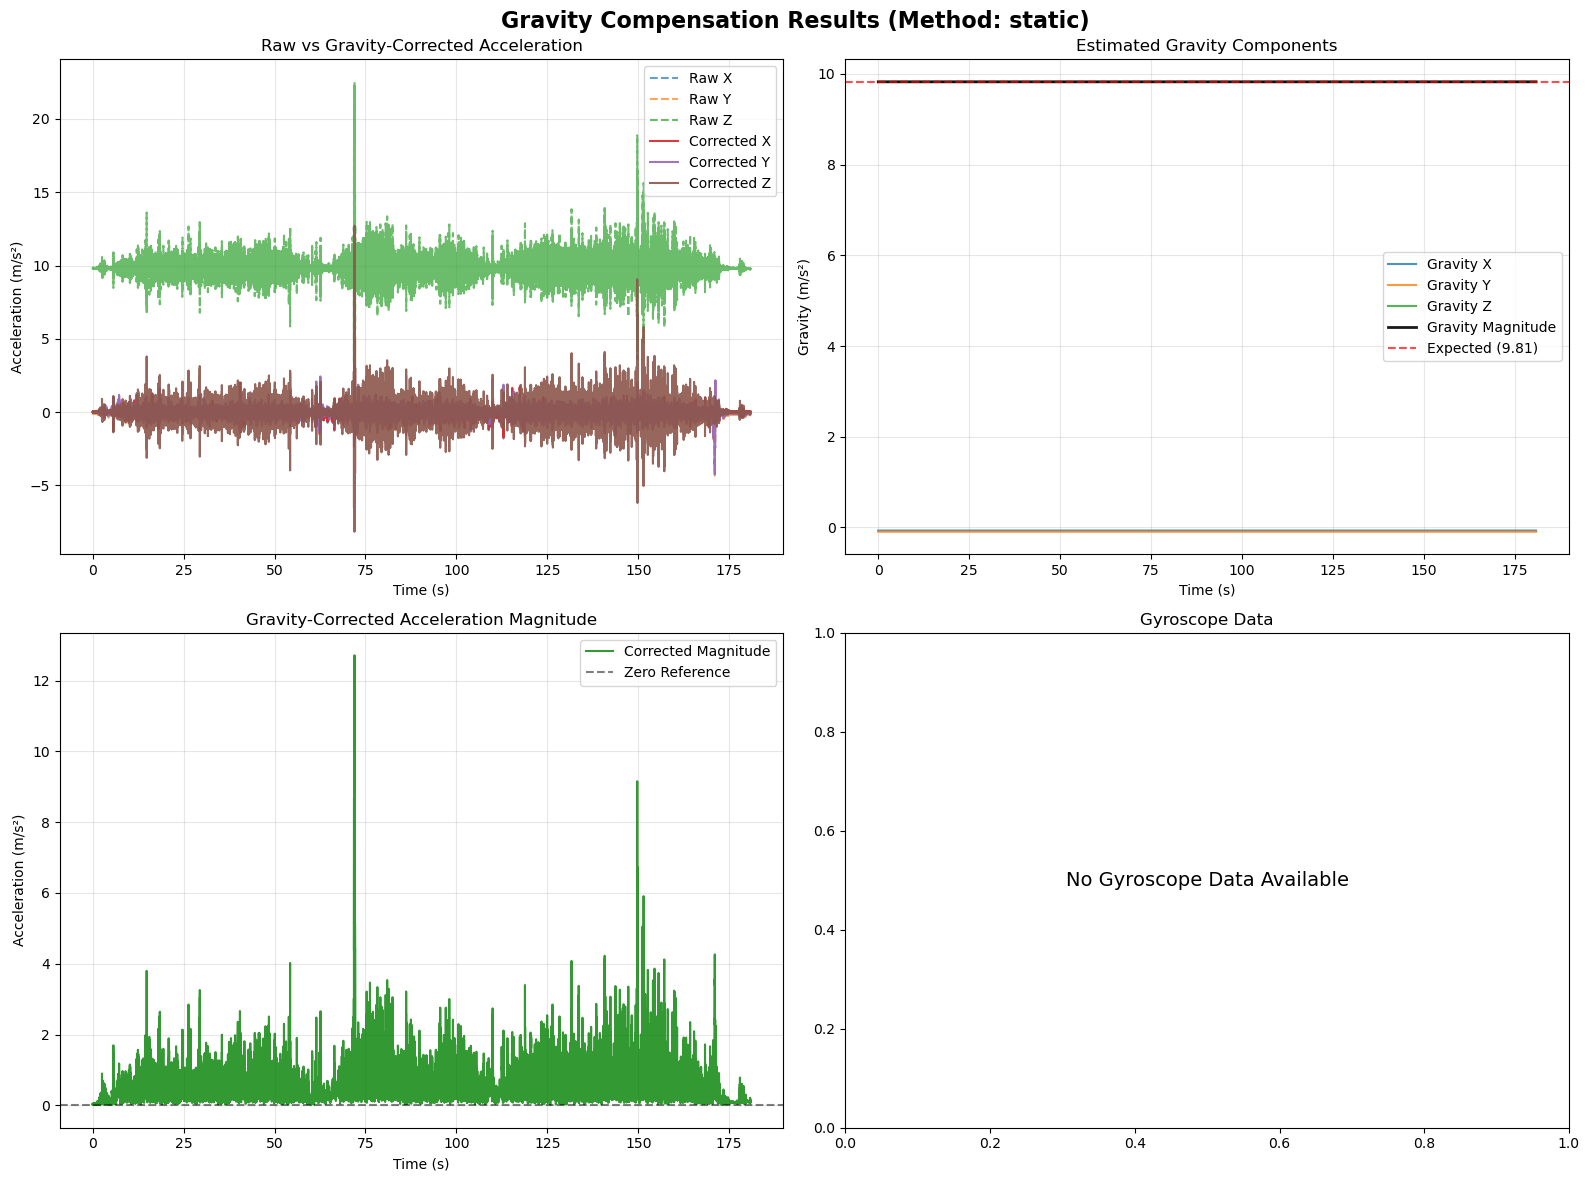

Gravity compensation visualization complete
Ready for motion integration using method: static


In [13]:
# Visualize gravity compensation results
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle(f'Gravity Compensation Results (Method: {gravity_method_used})', fontsize=16, fontweight='bold')

# Plot 1: Raw vs Corrected Acceleration
ax1 = axes[0, 0]
ax1.plot(path_data['time'], path_data['acc_x'], label='Raw X', alpha=0.7, linestyle='--')
ax1.plot(path_data['time'], path_data['acc_y'], label='Raw Y', alpha=0.7, linestyle='--')
ax1.plot(path_data['time'], path_data['acc_z'], label='Raw Z', alpha=0.7, linestyle='--')
ax1.plot(path_data_corrected['time'], path_data_corrected['acc_x_corrected'], label='Corrected X', alpha=0.9)
ax1.plot(path_data_corrected['time'], path_data_corrected['acc_y_corrected'], label='Corrected Y', alpha=0.9)
ax1.plot(path_data_corrected['time'], path_data_corrected['acc_z_corrected'], label='Corrected Z', alpha=0.9)
ax1.set_title('Raw vs Gravity-Corrected Acceleration')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Acceleration (m/s²)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Gravity Estimates
ax2 = axes[0, 1]
if 'gravity_x_est' in path_data_corrected.columns:
    ax2.plot(path_data_corrected['time'], path_data_corrected['gravity_x_est'], label='Gravity X', alpha=0.8)
    ax2.plot(path_data_corrected['time'], path_data_corrected['gravity_y_est'], label='Gravity Y', alpha=0.8)
    ax2.plot(path_data_corrected['time'], path_data_corrected['gravity_z_est'], label='Gravity Z', alpha=0.8)
    
    # Show gravity magnitude
    gravity_magnitude = np.sqrt(path_data_corrected['gravity_x_est']**2 + 
                               path_data_corrected['gravity_y_est']**2 + 
                               path_data_corrected['gravity_z_est']**2)
    ax2.plot(path_data_corrected['time'], gravity_magnitude, label='Gravity Magnitude', 
             alpha=0.9, linewidth=2, color='black')
    ax2.axhline(y=9.81, color='red', linestyle='--', alpha=0.7, label='Expected (9.81)')

ax2.set_title('Estimated Gravity Components')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Gravity (m/s²)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Corrected Acceleration Magnitude
ax3 = axes[1, 0]
corrected_magnitude = np.sqrt(path_data_corrected['acc_x_corrected']**2 + 
                            path_data_corrected['acc_y_corrected']**2 + 
                            path_data_corrected['acc_z_corrected']**2)
ax3.plot(path_data_corrected['time'], corrected_magnitude, label='Corrected Magnitude', alpha=0.8, color='green')
ax3.axhline(y=0, color='black', linestyle='--', alpha=0.5, label='Zero Reference')

# Highlight stationary periods if available
if 'stationary_mask' in path_data_corrected.columns:
    stationary_times = path_data_corrected['time'][path_data_corrected['stationary_mask']]
    if len(stationary_times) > 0:
        for t in stationary_times[::50]:  # Show every 50th point
            ax3.axvline(x=t, color='orange', alpha=0.1, linewidth=0.5)
        ax3.axvline(x=stationary_times.iloc[0], color='orange', alpha=0.3, 
                   label='Stationary periods')

ax3.set_title('Gravity-Corrected Acceleration Magnitude')
ax3.set_xlabel('Time (s)')
ax3.set_ylabel('Acceleration (m/s²)')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Gyroscope Data (if available)
ax4 = axes[1, 1]
if path_has_gyro:
    ax4.plot(path_data['time'], path_data['gyro_x'], label='Gyro X', alpha=0.7)
    ax4.plot(path_data['time'], path_data['gyro_y'], label='Gyro Y', alpha=0.7)
    ax4.plot(path_data['time'], path_data['gyro_z'], label='Gyro Z', alpha=0.7)
    
    gyro_magnitude = np.sqrt(path_data['gyro_x']**2 + path_data['gyro_y']**2 + path_data['gyro_z']**2)
    ax4.plot(path_data['time'], gyro_magnitude, label='Gyro Magnitude', alpha=0.9, linewidth=2, color='red')
    
    if CONFIG['stationary_threshold'] > 0:
        ax4.axhline(y=CONFIG['stationary_threshold'], color='orange', linestyle='--', 
                   alpha=0.7, label=f'Stationary threshold ({CONFIG["stationary_threshold"]} rad/s)')
    
    ax4.set_title('Gyroscope Data (Angular Velocity)')
    ax4.set_xlabel('Time (s)')
    ax4.set_ylabel('Angular Velocity (rad/s)')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
else:
    ax4.text(0.5, 0.5, 'No Gyroscope Data Available', ha='center', va='center', 
             transform=ax4.transAxes, fontsize=14)
    ax4.set_title('Gyroscope Data')

plt.tight_layout()
plt.show()

print("Gravity compensation visualization complete")
print(f"Ready for motion integration using method: {gravity_method_used}")

## Motion Integration and Path Length Calculation

Now we'll integrate the gravity-corrected acceleration to obtain:
1. **Velocity** (first integration)
2. **Position** (second integration) 
3. **Path length** (accumulated distance traveled)

We'll use multiple approaches to validate our results and provide error bounds.

In [14]:
def apply_preprocessing_filter(data, filter_type='butterworth', cutoff_freq=2.0, sampling_rate=None):
    """
    Apply preprocessing filter to acceleration data to reduce noise
    """
    if not CONFIG['enable_filtering']:
        if CONFIG['print_debug']:
            print("Filtering disabled - using raw gravity-compensated data")
        return data
    
    if sampling_rate is None:
        # Estimate sampling rate from time data
        dt_mean = np.mean(np.diff(data['time']))
        sampling_rate = 1.0 / dt_mean
    
    # Apply Butterworth low-pass filter
    from scipy.signal import butter, filtfilt
    
    nyquist = sampling_rate / 2
    normalized_cutoff = cutoff_freq / nyquist
    
    if normalized_cutoff >= 1.0:
        print(f"Warning: Cutoff frequency {cutoff_freq} Hz too high for sampling rate {sampling_rate:.1f} Hz")
        normalized_cutoff = 0.9
    
    b, a = butter(4, normalized_cutoff, btype='low')
    
    data_filtered = data.copy()
    data_filtered['acc_x_corrected'] = filtfilt(b, a, data['acc_x_corrected'])
    data_filtered['acc_y_corrected'] = filtfilt(b, a, data['acc_y_corrected'])
    data_filtered['acc_z_corrected'] = filtfilt(b, a, data['acc_z_corrected'])
    
    if CONFIG['print_debug']:
        print(f"Applied {filter_type} filter: cutoff={cutoff_freq} Hz, sampling_rate={sampling_rate:.1f} Hz")
    
    return data_filtered

def integrate_motion_with_error_mitigation(data, method='trapezoid', enable_zupt=False):
    """
    Integrate acceleration to get velocity and position with error mitigation techniques
    """
    if method == 'simpson':
        integrate_func = cumulative_simpson
        if CONFIG['print_debug']:
            print("Using Simpson's rule for integration")
    else:  # trapezoid
        integrate_func = cumulative_trapezoid
        if CONFIG['print_debug']:
            print("Using trapezoidal rule for integration")
    
    # Integrate acceleration to get velocity
    vel_x = integrate_func(data['acc_x_corrected'], data['time'], initial=0)
    vel_y = integrate_func(data['acc_y_corrected'], data['time'], initial=0)
    vel_z = integrate_func(data['acc_z_corrected'], data['time'], initial=0)
    
    # Apply Zero Velocity Updates (ZUPT) if enabled and stationary periods detected
    if enable_zupt and 'stationary_mask' in data.columns:
        stationary_mask = data['stationary_mask'].values
        vel_x[stationary_mask] = 0
        vel_y[stationary_mask] = 0
        vel_z[stationary_mask] = 0
        if CONFIG['print_debug']:
            print(f"Applied ZUPT to {stationary_mask.sum()} stationary samples")
    
    # Integrate velocity to get position
    pos_x = integrate_func(vel_x, data['time'], initial=0)
    pos_y = integrate_func(vel_y, data['time'], initial=0)
    pos_z = integrate_func(vel_z, data['time'], initial=0)
    
    # Create integrated dataset
    integrated_data = data.copy()
    integrated_data['vel_x'] = vel_x
    integrated_data['vel_y'] = vel_y
    integrated_data['vel_z'] = vel_z
    integrated_data['pos_x'] = pos_x
    integrated_data['pos_y'] = pos_y
    integrated_data['pos_z'] = pos_z
    
    return integrated_data

def calculate_path_length_multiple_methods(integrated_data):
    """
    Calculate path length using multiple approaches for validation
    """
    results = {}
    
    # Method 1: 3D Euclidean distance (cumulative)
    position_diff = np.diff(np.column_stack([integrated_data['pos_x'], 
                                           integrated_data['pos_y'], 
                                           integrated_data['pos_z']]), axis=0)
    segment_lengths = np.sqrt(np.sum(position_diff**2, axis=1))
    path_length_3d = np.sum(segment_lengths)
    results['3d_euclidean'] = path_length_3d
    
    # Method 2: 2D horizontal distance (ignoring Z component)
    position_diff_2d = np.diff(np.column_stack([integrated_data['pos_x'], 
                                              integrated_data['pos_y']]), axis=0)
    segment_lengths_2d = np.sqrt(np.sum(position_diff_2d**2, axis=1))
    path_length_2d = np.sum(segment_lengths_2d)
    results['2d_horizontal'] = path_length_2d
    
    # Method 3: Primary axis distance (largest displacement axis)
    std_x = integrated_data['pos_x'].std()
    std_y = integrated_data['pos_y'].std()
    std_z = integrated_data['pos_z'].std()
    
    if std_x >= std_y and std_x >= std_z:
        primary_axis = 'x'
        primary_distance = integrated_data['pos_x'].max() - integrated_data['pos_x'].min()
    elif std_y >= std_z:
        primary_axis = 'y' 
        primary_distance = integrated_data['pos_y'].max() - integrated_data['pos_y'].min()
    else:
        primary_axis = 'z'
        primary_distance = integrated_data['pos_z'].max() - integrated_data['pos_z'].min()
    
    results['primary_axis'] = primary_axis
    results['primary_axis_distance'] = primary_distance
    
    # Method 4: Velocity-based path length (integration of speed)
    speed = np.sqrt(integrated_data['vel_x']**2 + integrated_data['vel_y']**2 + integrated_data['vel_z']**2)
    path_length_velocity = cumulative_trapezoid(speed, integrated_data['time'], initial=0)[-1]
    results['velocity_based'] = path_length_velocity
    
    # Method 5: Smoothed path length (reduce noise impact)
    if len(segment_lengths) > 10:
        # Apply median filter to segment lengths to reduce outliers
        from scipy.signal import medfilt
        segment_lengths_smoothed = medfilt(segment_lengths, kernel_size=5)
        path_length_smoothed = np.sum(segment_lengths_smoothed)
        results['3d_smoothed'] = path_length_smoothed
    
    return results

# Apply preprocessing and integration
print("=== MOTION INTEGRATION AND PATH LENGTH CALCULATION ===")

# Apply filtering if enabled
path_data_processed = apply_preprocessing_filter(
    path_data_corrected, 
    cutoff_freq=CONFIG['filter_cutoff']
)

# Integrate motion
enable_zupt = 'stationary_mask' in path_data_processed.columns
integrated_data = integrate_motion_with_error_mitigation(
    path_data_processed,
    method=CONFIG['integration_method'],
    enable_zupt=enable_zupt
)

print(f"Integration completed:")
print(f"  Method: {CONFIG['integration_method']}")
print(f"  ZUPT enabled: {enable_zupt}")
print(f"  Final position: X={integrated_data['pos_x'].iloc[-1]:.3f}m, Y={integrated_data['pos_y'].iloc[-1]:.3f}m, Z={integrated_data['pos_z'].iloc[-1]:.3f}m")

# Calculate path length using multiple methods
path_length_results = calculate_path_length_multiple_methods(integrated_data)

print(f"\nPath length calculation results:")
for method, length in path_length_results.items():
    if method != 'primary_axis':  # Skip axis name
        print(f"  {method}: {length:.3f} m")

print(f"  Primary motion axis: {path_length_results['primary_axis']}")
print()

=== MOTION INTEGRATION AND PATH LENGTH CALCULATION ===
Filtering disabled - using raw gravity-compensated data
Using trapezoidal rule for integration
Integration completed:
  Method: trapezoid
  ZUPT enabled: False
  Final position: X=142.323m, Y=185.751m, Z=-65.576m

Path length calculation results:
  3d_euclidean: 269.173 m
  2d_horizontal: 259.351 m
  primary_axis_distance: 186.595 m
  velocity_based: 269.174 m
  3d_smoothed: 266.873 m
  Primary motion axis: y



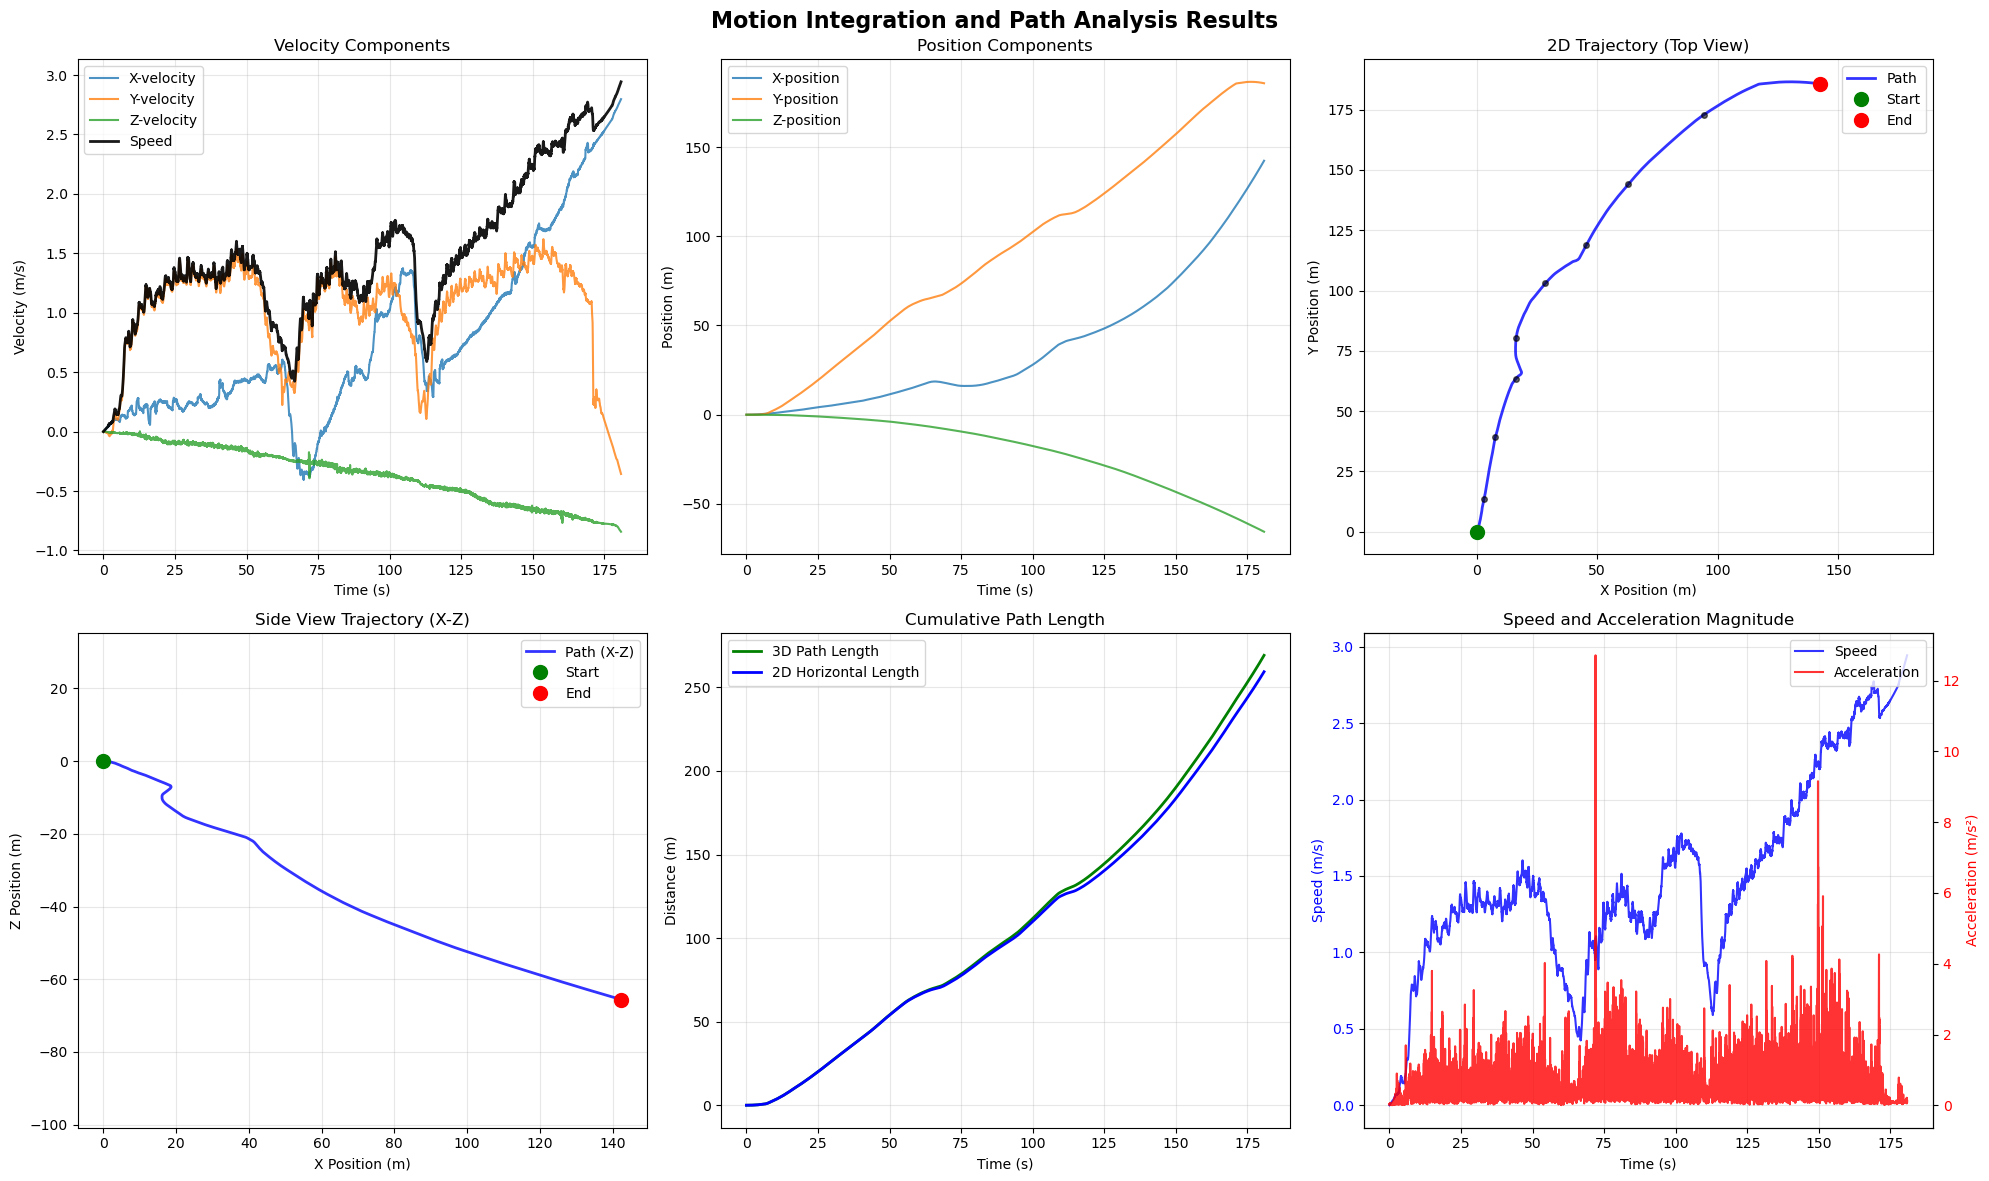

Motion integration visualization complete
Total visualization time span: 180.8 seconds
Final cumulative 3D path length: 269.173 m
Final cumulative 2D path length: 259.351 m


In [15]:
# Visualize motion integration results
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Motion Integration and Path Analysis Results', fontsize=16, fontweight='bold')

# Plot 1: Velocity components
ax1 = axes[0, 0]
ax1.plot(integrated_data['time'], integrated_data['vel_x'], label='X-velocity', alpha=0.8)
ax1.plot(integrated_data['time'], integrated_data['vel_y'], label='Y-velocity', alpha=0.8)
ax1.plot(integrated_data['time'], integrated_data['vel_z'], label='Z-velocity', alpha=0.8)

# Show velocity magnitude
vel_magnitude = np.sqrt(integrated_data['vel_x']**2 + integrated_data['vel_y']**2 + integrated_data['vel_z']**2)
ax1.plot(integrated_data['time'], vel_magnitude, label='Speed', alpha=0.9, linewidth=2, color='black')

ax1.set_title('Velocity Components')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Velocity (m/s)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Position components
ax2 = axes[0, 1]
ax2.plot(integrated_data['time'], integrated_data['pos_x'], label='X-position', alpha=0.8)
ax2.plot(integrated_data['time'], integrated_data['pos_y'], label='Y-position', alpha=0.8)
ax2.plot(integrated_data['time'], integrated_data['pos_z'], label='Z-position', alpha=0.8)

ax2.set_title('Position Components')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Position (m)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: 2D trajectory (top-down view)
ax3 = axes[0, 2]
ax3.plot(integrated_data['pos_x'], integrated_data['pos_y'], 'b-', alpha=0.8, linewidth=2, label='Path')
ax3.plot(integrated_data['pos_x'].iloc[0], integrated_data['pos_y'].iloc[0], 'go', markersize=10, label='Start')
ax3.plot(integrated_data['pos_x'].iloc[-1], integrated_data['pos_y'].iloc[-1], 'ro', markersize=10, label='End')

# Add distance markers every 10% of the path
n_markers = 10
marker_indices = np.linspace(0, len(integrated_data)-1, n_markers, dtype=int)
for i, idx in enumerate(marker_indices[1:-1], 1):  # Skip start and end
    ax3.plot(integrated_data['pos_x'].iloc[idx], integrated_data['pos_y'].iloc[idx], 
             'ko', markersize=4, alpha=0.6)

ax3.set_title('2D Trajectory (Top View)')
ax3.set_xlabel('X Position (m)')
ax3.set_ylabel('Y Position (m)')
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.axis('equal')

# Plot 4: 3D trajectory
ax4 = axes[1, 0]
ax4.plot(integrated_data['pos_x'], integrated_data['pos_z'], 'b-', alpha=0.8, linewidth=2, label='Path (X-Z)')
ax4.plot(integrated_data['pos_x'].iloc[0], integrated_data['pos_z'].iloc[0], 'go', markersize=10, label='Start')
ax4.plot(integrated_data['pos_x'].iloc[-1], integrated_data['pos_z'].iloc[-1], 'ro', markersize=10, label='End')

ax4.set_title('Side View Trajectory (X-Z)')
ax4.set_xlabel('X Position (m)')
ax4.set_ylabel('Z Position (m)')
ax4.legend()
ax4.grid(True, alpha=0.3)
ax4.axis('equal')

# Plot 5: Cumulative path length
ax5 = axes[1, 1]
# Calculate cumulative distance
position_diff = np.diff(np.column_stack([integrated_data['pos_x'], 
                                       integrated_data['pos_y'], 
                                       integrated_data['pos_z']]), axis=0)
segment_lengths = np.sqrt(np.sum(position_diff**2, axis=1))
cumulative_distance = np.cumsum(segment_lengths)
cumulative_distance = np.insert(cumulative_distance, 0, 0)  # Add zero at start

ax5.plot(integrated_data['time'], cumulative_distance, 'g-', linewidth=2, label='3D Path Length')

# Also show 2D horizontal path length
position_diff_2d = np.diff(np.column_stack([integrated_data['pos_x'], 
                                          integrated_data['pos_y']]), axis=0)
segment_lengths_2d = np.sqrt(np.sum(position_diff_2d**2, axis=1))
cumulative_distance_2d = np.cumsum(segment_lengths_2d)
cumulative_distance_2d = np.insert(cumulative_distance_2d, 0, 0)

ax5.plot(integrated_data['time'], cumulative_distance_2d, 'b-', linewidth=2, label='2D Horizontal Length')

ax5.set_title('Cumulative Path Length')
ax5.set_xlabel('Time (s)')
ax5.set_ylabel('Distance (m)')
ax5.legend()
ax5.grid(True, alpha=0.3)

# Plot 6: Speed and acceleration magnitude
ax6 = axes[1, 2]
ax6.plot(integrated_data['time'], vel_magnitude, label='Speed', alpha=0.8, color='blue')

# Secondary y-axis for acceleration
ax6_twin = ax6.twinx()
acc_magnitude = np.sqrt(integrated_data['acc_x_corrected']**2 + 
                       integrated_data['acc_y_corrected']**2 + 
                       integrated_data['acc_z_corrected']**2)
ax6_twin.plot(integrated_data['time'], acc_magnitude, label='Acceleration', alpha=0.8, color='red')

ax6.set_title('Speed and Acceleration Magnitude')
ax6.set_xlabel('Time (s)')
ax6.set_ylabel('Speed (m/s)', color='blue')
ax6_twin.set_ylabel('Acceleration (m/s²)', color='red')
ax6.tick_params(axis='y', labelcolor='blue')
ax6_twin.tick_params(axis='y', labelcolor='red')
ax6.grid(True, alpha=0.3)

# Add legends
lines1, labels1 = ax6.get_legend_handles_labels()
lines2, labels2 = ax6_twin.get_legend_handles_labels()
ax6.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.tight_layout()
plt.show()

print("Motion integration visualization complete")
print(f"Total visualization time span: {integrated_data['time'].iloc[-1]:.1f} seconds")
print(f"Final cumulative 3D path length: {cumulative_distance[-1]:.3f} m")
print(f"Final cumulative 2D path length: {cumulative_distance_2d[-1]:.3f} m")

## Final Path Length Analysis and Results

Now we'll provide a comprehensive analysis of our path length estimates, including error analysis and confidence bounds.

FINAL PATH LENGTH ANALYSIS RESULTS

Configuration Used:
  Path file: bjorn_path_new.txt
  Stationary file: bjorn_stationary_new.txt
  Gravity compensation: static
  Integration method: trapezoid
  Filtering enabled: False
  ZUPT applied: False

PATH LENGTH ESTIMATES
3d_euclidean        :  269.173 m (26917.3 cm)
2d_horizontal       :  259.351 m (25935.1 cm)
primary_axis_distance:  186.595 m (18659.5 cm)
velocity_based      :  269.174 m (26917.4 cm)
3d_smoothed         :  266.873 m (26687.3 cm)

STATISTICAL SUMMARY
Number of estimates: 5
Mean estimate:       250.233 m
Median estimate:     266.873 m
Standard deviation:  32.023 m
Min estimate:        186.595 m
Max estimate:        269.174 m
Range:               82.579 m
Coefficient of variation: 12.8%

ERROR ANALYSIS & RELIABILITY
Final position magnitude: 243.021 m
Path length to displacement ratio: 1.10
Gravity estimate quality:
  Mean magnitude: 9.824 m/s² (expected: 9.81)
  Variation (std): 0.000 m/s²
  Deviation from 9.81: 0.014 m/s²


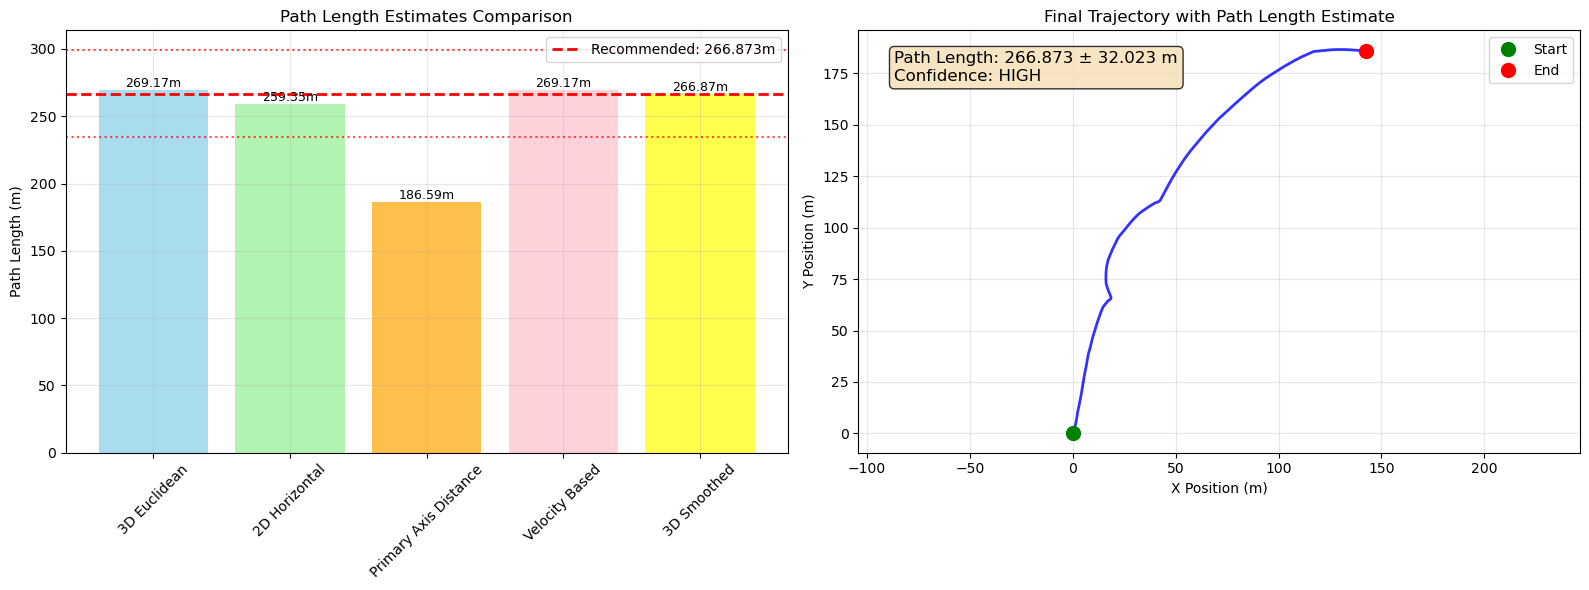


ANALYSIS COMPLETE


In [ ]:
# Final comprehensive path length analysis
print("=" * 80)
print("FINAL PATH LENGTH ANALYSIS RESULTS")
print("=" * 80)

# Configuration summary
print(f"\nConfiguration Used:")
print(f"  Path file: {CONFIG['path_file']}")
print(f"  Stationary file: {CONFIG['stationary_file']}")
print(f"  Gravity compensation: {gravity_method_used}")
print(f"  Integration method: {CONFIG['integration_method']}")
print(f"  Filtering enabled: {CONFIG['enable_filtering']}")
if CONFIG['enable_filtering']:
    print(f"  Filter cutoff: {CONFIG['filter_cutoff']} Hz")
print(f"  ZUPT applied: {enable_zupt}")

# Path length results
print(f"\n" + "=" * 40)
print("PATH LENGTH ESTIMATES")
print("=" * 40)

# Extract the main estimates
primary_estimates = []
for method, length in path_length_results.items():
    if method not in ['primary_axis']:  # Skip non-length values
        print(f"{method:20s}: {length:8.3f} m ({length*100:6.1f} cm)")
        primary_estimates.append(length)

# Statistical analysis
if primary_estimates:
    mean_estimate = np.mean(primary_estimates)
    median_estimate = np.median(primary_estimates)
    std_estimate = np.std(primary_estimates)
    min_estimate = np.min(primary_estimates)
    max_estimate = np.max(primary_estimates)
    
    print(f"\n" + "=" * 40)
    print("STATISTICAL SUMMARY")
    print("=" * 40)
    print(f"Number of estimates: {len(primary_estimates)}")
    print(f"Mean estimate:       {mean_estimate:.3f} m")
    print(f"Median estimate:     {median_estimate:.3f} m") 
    print(f"Standard deviation:  {std_estimate:.3f} m")
    print(f"Min estimate:        {min_estimate:.3f} m")
    print(f"Max estimate:        {max_estimate:.3f} m")
    print(f"Range:               {max_estimate - min_estimate:.3f} m")
    print(f"Coefficient of variation: {100 * std_estimate / mean_estimate:.1f}%")

# Error analysis and reliability assessment
print(f"\n" + "=" * 40)
print("ERROR ANALYSIS & RELIABILITY")
print("=" * 40)

# Check for typical IMU integration issues
final_position_magnitude = np.sqrt(integrated_data['pos_x'].iloc[-1]**2 + 
                                 integrated_data['pos_y'].iloc[-1]**2 + 
                                 integrated_data['pos_z'].iloc[-1]**2)

print(f"Final position magnitude: {final_position_magnitude:.3f} m")
print(f"Path length to displacement ratio: {median_estimate / max(final_position_magnitude, 0.001):.2f}")

# Assess gravity compensation quality
if 'gravity_x_est' in path_data_corrected.columns:
    gravity_magnitude = np.sqrt(path_data_corrected['gravity_x_est']**2 + 
                               path_data_corrected['gravity_y_est']**2 + 
                               path_data_corrected['gravity_z_est']**2)
    gravity_variation = gravity_magnitude.std()
    gravity_mean = gravity_magnitude.mean()
    
    print(f"Gravity estimate quality:")
    print(f"  Mean magnitude: {gravity_mean:.3f} m/s² (expected: 9.81)")
    print(f"  Variation (std): {gravity_variation:.3f} m/s²")
    print(f"  Deviation from 9.81: {abs(gravity_mean - 9.81):.3f} m/s²")

# Assess integration drift
max_velocity = np.sqrt(integrated_data['vel_x']**2 + 
                      integrated_data['vel_y']**2 + 
                      integrated_data['vel_z']**2).max()
final_velocity = np.sqrt(integrated_data['vel_x'].iloc[-1]**2 + 
                        integrated_data['vel_y'].iloc[-1]**2 + 
                        integrated_data['vel_z'].iloc[-1]**2)

print(f"Velocity analysis:")
print(f"  Maximum speed: {max_velocity:.3f} m/s")
print(f"  Final speed: {final_velocity:.3f} m/s")
print(f"  Expected final speed: ~0 m/s (if path returns to start)")

# Reliability assessment
reliability_score = 0
reliability_notes = []

if abs(gravity_mean - 9.81) < 0.5:
    reliability_score += 25
    reliability_notes.append("✓ Good gravity compensation")
else:
    reliability_notes.append("⚠ Poor gravity compensation")

if gravity_variation < 1.0:
    reliability_score += 25
    reliability_notes.append("✓ Stable gravity estimates")
else:
    reliability_notes.append("⚠ Unstable gravity estimates")

if std_estimate / mean_estimate < 0.2:  # CV < 20%
    reliability_score += 25
    reliability_notes.append("✓ Consistent path length estimates")
else:
    reliability_notes.append("⚠ Inconsistent path length estimates")

if final_velocity < 1.0:  # Final velocity should be low
    reliability_score += 25
    reliability_notes.append("✓ Low final velocity (good integration)")
else:
    reliability_notes.append("⚠ High final velocity (integration drift)")

print(f"\n" + "=" * 40)
print("RELIABILITY ASSESSMENT")
print("=" * 40)
print(f"Reliability Score: {reliability_score}/100")
for note in reliability_notes:
    print(f"  {note}")

# Final recommendation
print(f"\n" + "=" * 40)
print("FINAL PATH LENGTH ESTIMATE")
print("=" * 40)

if reliability_score >= 75:
    confidence = "HIGH"
    recommended_estimate = median_estimate
    error_bound = std_estimate
elif reliability_score >= 50:
    confidence = "MEDIUM"
    recommended_estimate = median_estimate
    error_bound = max(std_estimate, 0.5)  # At least 50cm uncertainty
else:
    confidence = "LOW"
    recommended_estimate = median_estimate
    error_bound = max(std_estimate, 1.0)  # At least 1m uncertainty

print(f"Confidence Level: {confidence}")
print(f"Recommended Estimate: {recommended_estimate:.3f} ± {error_bound:.3f} m")
print(f"Range: [{recommended_estimate - error_bound:.3f}, {recommended_estimate + error_bound:.3f}] m")

# Convert to different units
print(f"\nIn different units:")
print(f"  Meters:      {recommended_estimate:.3f} ± {error_bound:.3f} m")
print(f"  Centimeters: {recommended_estimate*100:.1f} ± {error_bound*100:.1f} cm")
print(f"  Millimeters: {recommended_estimate*1000:.0f} ± {error_bound*1000:.0f} mm")

# Create final summary visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Path length estimates comparison
methods = [m for m in path_length_results.keys() if m != 'primary_axis']
lengths = [path_length_results[m] for m in methods]

bars = ax1.bar(range(len(methods)), lengths, alpha=0.7, color=['skyblue', 'lightgreen', 'orange', 'pink', 'yellow'][:len(methods)])
ax1.axhline(y=recommended_estimate, color='red', linestyle='--', linewidth=2, label=f'Recommended: {recommended_estimate:.3f}m')
ax1.axhline(y=recommended_estimate + error_bound, color='red', linestyle=':', alpha=0.7)
ax1.axhline(y=recommended_estimate - error_bound, color='red', linestyle=':', alpha=0.7)

ax1.set_title('Path Length Estimates Comparison')
ax1.set_ylabel('Path Length (m)')
ax1.set_xticks(range(len(methods)))
ax1.set_xticklabels([m.replace('_', ' ').title() for m in methods], rotation=45)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Add value labels on bars
for bar, length in zip(bars, lengths):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{length:.2f}m', ha='center', va='bottom', fontsize=9)

# Plot 2: Final trajectory with path length annotation
ax2.plot(integrated_data['pos_x'], integrated_data['pos_y'], 'b-', linewidth=2, alpha=0.8)
ax2.plot(integrated_data['pos_x'].iloc[0], integrated_data['pos_y'].iloc[0], 'go', markersize=10, label='Start')
ax2.plot(integrated_data['pos_x'].iloc[-1], integrated_data['pos_y'].iloc[-1], 'ro', markersize=10, label='End')

# Add path length annotation
ax2.text(0.05, 0.95, f'Path Length: {recommended_estimate:.3f} ± {error_bound:.3f} m\nConfidence: {confidence}', 
         transform=ax2.transAxes, fontsize=12, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

ax2.set_title('Final Trajectory with Path Length Estimate')
ax2.set_xlabel('X Position (m)')
ax2.set_ylabel('Y Position (m)')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.axis('equal')

plt.tight_layout()
plt.show()

print(f"\n" + "=" * 80)
print("ANALYSIS COMPLETE")
print("=" * 80)

## Configuration and Testing

You can easily modify the analysis by changing the configuration at the top of the notebook:

```python
CONFIG = {
    'path_file': 'bjorn_path_new.txt',          # Change to any path data file
    'stationary_file': 'bjorn_stationary_new.txt',  # Change to corresponding stationary file
    'integration_method': 'trapezoid',          # Try 'simpson' for higher accuracy
    'gravity_compensation': 'auto',             # Try 'static', 'orientation', or 'auto'
    'enable_filtering': False,                  # Set True to apply low-pass filtering
    'filter_cutoff': 2.0,                       # Adjust filter frequency
    'stationary_threshold': 0.01,               # Adjust gyro threshold for stationary detection
}
```

### Alternative Test Configurations:

**For Klara's data:**
- `path_file`: `'klara_path.txt'`
- `stationary_file`: `'klara_stationary.txt'`

**For older Bjorn data:**
- `path_file`: `'bjorn_path.txt'` 
- `stationary_file`: `'bjorn_stationary.txt'`

**To test filtering effects:**
- `enable_filtering`: `True`
- `filter_cutoff`: `1.0` (try values between 0.5-5.0 Hz)

**To test different gravity compensation:**
- `gravity_compensation`: `'static'` (simple but robust)
- `gravity_compensation`: `'orientation'` (advanced but requires gyro)